# Calm Water Resistance Model

> Library for calm water resistance model

In [ ]:
# | default_exp calm_water_resistance
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# | hide
from nbdev.showdoc import *

## Speed Power Curve
The propulsion power is defined by a prescribed curve between speed in kn (nautical mile per hour) and power in kW.

In [ ]:
# | export
from abc import ABC
from typing import Callable, Union, TypeVar
from functools import cached_property
from scipy.optimize import brentq
from dataclasses import dataclass
import logging

import numpy as np
from ship_model_lib.utility import get_interpolation_1d_function, Interpolated1DValue
from ship_model_lib.types import ResistanceLevel

# Define logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)

formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
ch.setFormatter(formatter)

logger.addHandler(ch)

Numeric = TypeVar("Numeric", float, np.ndarray)


class CalmWaterResistanceBase(ABC):
    """
    Abstract class for calm water resistance model
    """

    speed_ref_kn: np.ndarray
    _y: np.ndarray
    draft_m: float = 0
    trim_deg: float = 0

    @cached_property
    def _speed_to_y_interpolation_function(
        self, kind: Union[str, int] = "cubic"
    ) -> Callable[[Numeric], Interpolated1DValue]:
        """Returns a interpolation function for propulsion speed in waves in respect to a given
        power

        Arguments:
            kind: Specifies the kind of interpolation as a string or as an integer specifying
                the order of the spline interpolator to use. Refer to the documentation for
                scipy.interpolate.interp1d. Default is 'cubic'
        """
        return get_interpolation_1d_function(
            x=self.speed_ref_kn, y=self._y, kind=kind, add_origo=True
        )

    @cached_property
    def _y_to_speed_interpolation_function(
        self, kind: Union[str, int] = "cubic"
    ) -> Callable[[Numeric], Interpolated1DValue]:
        """Return an interpolation function for propulsion power in waves in respect to a given
        speed

        Arguments:
            kind: Specifies the kind of interpolation as a string or as an integer specifying
                the order of the spline interpolator to use. Refer to the documentation for
                scipy.interpolate.interp1d. Default is 'cubic'
        """
        speed_to_y_curve = self._speed_to_y_interpolation_function

        # Find speeds that corresponds to the equidistant y array. We will have a denser
        # for lower values of power.
        y_max = self._y.max()
        num_points = [
            {"from": 0, "to": y_max * 0.01, "num_points": 100},
            {"from": y_max * 0.01, "to": y_max * 0.05, "num_points": 50},
            {"from": y_max * 0.05, "to": y_max * 0.2, "num_points": 50},
            {"from": y_max * 0.2, "to": y_max, "num_points": 50},
        ]
        x_data: np.ndarray = np.array([])
        for interval in num_points:
            step = (interval["to"] - interval["from"]) / (interval["num_points"] - 1)
            x_data = np.append(
                x_data, np.arange(interval["from"], interval["to"], step)
            )  # type: ignore[no-untyped-call]
        x_data = np.append(x_data, y_max)  # type: ignore[no-untyped-call]
        y_data = np.zeros(x_data.shape)  # type: ignore[no-untyped-call]
        for index, x_i in enumerate(x_data):
            y_data[index] = brentq(
                f=lambda x, y: speed_to_y_curve(x).value - y,
                a=0,
                b=self.speed_ref_kn.max(),
                args=x_i,
            )

        return get_interpolation_1d_function(
            x=x_data, y=y_data, kind=kind, add_origo=True
        )


class CalmWaterResistanceBySpeedPowerCurve(CalmWaterResistanceBase):
    """
    Class for calm water resistance that is specified by the speed power curve.

    Exceptions:
        - TypeError when you set the power_ref_kw array that is different in length from that of speed_ref_kn
    """

    def __init__(
        self,
        *,
        speed_ref_kn: np.ndarray,
        power_ref_kw: np.ndarray,
        draft_m: float = 0,
        trim_deg=0
    ):
        self.speed_ref_kn = speed_ref_kn
        self.power_ref_kw = power_ref_kw
        self.draft_m = draft_m
        self.trim_deg = trim_deg

    @property
    def power_ref_kw(self) -> np.ndarray:
        return self._y

    @power_ref_kw.setter
    def power_ref_kw(self, value):
        if len(value) != len(self.speed_ref_kn):
            raise TypeError(
                "The length of the power_ref_kw is not the same as that of speed_ref_kn"
            )
        self._y = value

    def get_power_from_speed(self, speed_kn: Numeric) -> Interpolated1DValue:
        return self._speed_to_y_interpolation_function(speed_kn)

    def get_speed_from_power(self, power_kw: Numeric) -> Interpolated1DValue:
        return self._y_to_speed_interpolation_function(power_kw)


@dataclass
class CalmWaterResistanceBySpeedResistanceCurve(CalmWaterResistanceBase):
    """
    Class for calm water resistance that is specified by the speed resistance curve.

    Exceptions:
        - TypeError when you set the power_ref_kw array that is different in length from that of speed_ref_kn
    """

    def __init__(
        self,
        *,
        speed_ref_kn: np.ndarray,
        resistance_ref_k_n: np.ndarray,
        draft_m: float = 0,
        trim_deg=0
    ):
        self.speed_ref_kn = speed_ref_kn
        self.resistance_ref_k_n = resistance_ref_k_n
        self.draft_m = draft_m
        self.trim_deg = trim_deg

    @property
    def resistance_ref_k_n(self) -> np.ndarray:
        return self._y

    @resistance_ref_k_n.setter
    def resistance_ref_k_n(self, value):
        if len(value) != len(self.speed_ref_kn):
            raise TypeError(
                "The length of the power_ref_kw is not the same as that of speed_ref_kn"
            )
        self._y = value

    def get_resistance_from_speed(self, velocity_kn: Numeric) -> Interpolated1DValue:
        return self._speed_to_y_interpolation_function(velocity_kn)

    def get_speed_from_resistance(self, resistance_k_n: Numeric) -> Interpolated1DValue:
        return self._y_to_speed_interpolation_function(resistance_k_n)

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()

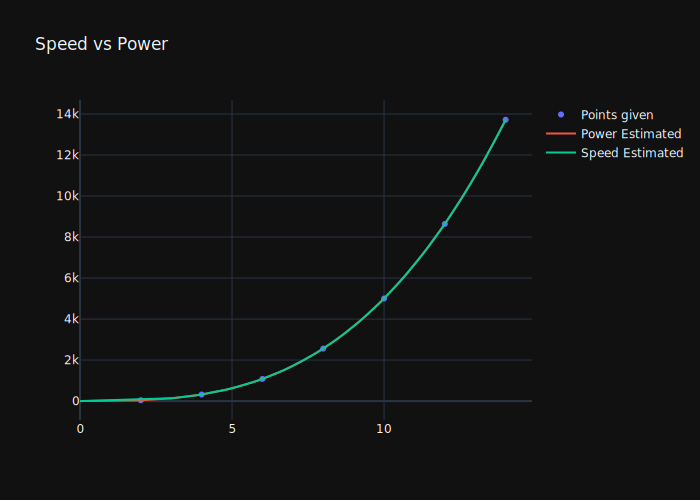

In [ ]:
from ship_model_lib.calm_water_resistance import (
    CalmWaterResistanceBySpeedPowerCurve,
    CalmWaterResistanceBySpeedResistanceCurve,
)
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import pandas as pd

speed_kn = np.array([2, 4, 6, 8, 10, 12, 14])
power_kw = np.power(speed_kn, 3) * 5

fig = make_subplots()
fig.add_trace(go.Scatter(x=speed_kn, y=power_kw, mode="markers", name="Points given"))

resistance_model = CalmWaterResistanceBySpeedPowerCurve(
    speed_ref_kn=speed_kn, power_ref_kw=power_kw
)
speed_new = np.linspace(0, speed_kn.max(), 100)
power_estimated = resistance_model.get_power_from_speed(speed_kn=speed_new)
fig.add_trace(go.Scatter(x=speed_new, y=power_estimated.value, name="Power Estimated"))
power_new = np.linspace(0, power_kw.max(), 100)
speed_estimated = resistance_model.get_speed_from_power(power_kw=power_new)
fig.add_trace(go.Scatter(x=speed_estimated.value, y=power_new, name="Speed Estimated"))
fig.update_layout(title="Speed vs Power")
fig.show(renderer="svg")

df = pd.read_csv("test_data/hollenbach_design_draft_resistance.csv")

In [ ]:
print(df.vs)
power_estimated = resistance_model.get_power_from_speed(speed_kn=df.vs.values).value
print(power_estimated)

0    15.0
1    15.5
2    16.0
3    16.5
4    17.0
5    17.5
6    18.0
7    18.5
8    19.0
Name: vs, dtype: float64
[16875.    18619.375 20480.    22460.625 24565.    26796.875 29160.
 31658.125 34295.   ]


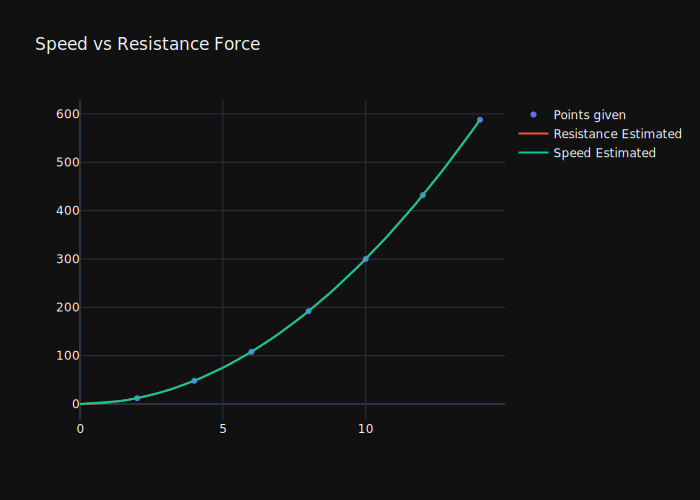

In [ ]:
resistance_k_n = np.power(speed_kn, 2) * 3

fig = make_subplots()
fig.add_trace(
    go.Scatter(x=speed_kn, y=resistance_k_n, mode="markers", name="Points given")
)

resistance_model = CalmWaterResistanceBySpeedResistanceCurve(
    speed_ref_kn=speed_kn, resistance_ref_k_n=resistance_k_n
)
speed_new = np.linspace(0, speed_kn.max(), 100)
resistance_estimated = resistance_model.get_resistance_from_speed(velocity_kn=speed_new)
fig.add_trace(
    go.Scatter(x=speed_new, y=resistance_estimated.value, name="Resistance Estimated")
)
resistance_new = np.linspace(0, resistance_k_n.max(), 100)
speed_estimated = resistance_model.get_speed_from_resistance(
    resistance_k_n=resistance_new
)
fig.add_trace(
    go.Scatter(x=speed_estimated.value, y=resistance_new, name="Speed Estimated")
)
fig.update_layout(title="Speed vs Resistance Force")
fig.show(renderer="svg")

## HOllenbach Method
"""Hollenbach’s model is an estimate of the power requirement of a ship, which focuses on the pre- diction of the resistance in calm water. The model is based on regression analysis of 433 ship models, and depends on the vessels main dimensions. The important details in the hull will therefore not have much of an effect in the resistance prediction. Hollenbach is the most recent empirical method for commercial vessels, and more accurate than other methods like Holtrop and Guldhammer-Harvald, as it uses a wider set of data and more complex formulas. The method separates the results in best and poor, with a difference of 5%. This gives the user the opportunity to decide whether the hull has good or poor hull lines.

The total resistance is expresses as follows:

$$R_{T} = \frac{1}{2}\rho V^2 S C_{T}$$

where, $S$ is the wetted surface area, $\rho$ is density of the sea water, and $C_{T}$ is a friction coefficient. $C_{T}$ can be calculated as:

$$C_{T} = C_{F} + C_{R}$$

where the viscous friction coefficient $C_F$ can be calculated as follows:
$$C_{F} = \frac{0.075}{\left(\log Re - 2\right)^2}$$
$$Re = \frac{6 F_n \sqrt{6g}}{1.1395} \cdot 10^6$$

The term for the residual friction coefficint $C_R$ is calculated
$$C_{R, std} = b_{11} + b_{13} F_n + b_{13} F_n ^2 + C_B \left(b_{21} + b_{22}F_n + b_{23} F_n ^2 \right) + C_B ^2 \left(b_{31} + b_{32}F_n + b_{33} F_n ^2 \right)$$
$$C_{R} = C_{R, std}C_{R, FnKrit} k_L \left(\frac{T}{B}\right)^{a_1} \left(\frac{B}{L}\right)^{a_2} \left(\frac{L_{OS}}{L_{WL}}\right)^{a_3} \left(\frac{L_{WL}}{L_{pp}}\right)^{a_4} \left(\frac{D_p}{T_A}\right)^{a_6}$$"""

In [ ]:
# | export
from typing import Optional
from abc import ABC, abstractmethod
from typing import List, Tuple, Union
from enum import Enum

# from mes_util.constants import KINEMATIC_VISCOSITY_WATER
from ship_model_lib.ship_dimensions import (
    ShipDimensionsHollenbachSingleScrew,
    ShipDimensionsHollenbachTwinScrew,
)
import numpy as np
from scipy.optimize import root_scalar

GRAVITY = 9.81
KINEMATIC_VISCOSITY_WATER = 1.189e-6


def kn_to_m_per_s(v_kn: Numeric) -> Numeric:
    return v_kn * 0.5144


class CalmWaterResistanceHollenbachBase(ABC):
    _coeff_for_shape_factor: np.ndarray = np.array([])
    _coeff_for_length_factor1: float = 1.0  # e1
    _coeff_for_length_factor2: float = 0  # e2
    _coeff_for_beam_draft_ratio_factor: float = 0  # a1
    _coeff_for_length_beam_ratio_factor: float = 0  # a2
    _coeff_for_wetted_length_ratio_factor: float = 0  # a3
    _coeff_for_aft_overhang_ratio_factor: float = 0  # a4
    _coeff_for_trim_correct_factor: float = 0  # a5
    _coeff_for_propeller_factor: float = 0  # a6
    _coeff_for_std_residual_coefficient: np.ndarray = np.array([])
    _coeff_for_critical_froude_number: np.ndarray = np.array([])
    _factor_for_max_resistance: float = 1
    _coeff_for_min_std_residual_coefficient: np.ndarray = np.array([])
    _coeff_air_drag = 0.8

    def __init__(self, ship_dimensions):
        self.b_beam = ship_dimensions.b_beam_m
        self.l_length_between_perpendiculars = (
            ship_dimensions.lpp_length_between_perpendiculars_m
        )
        self.ta_draft_aft = ship_dimensions.ta_draft_aft_m
        self.tf_draft_forward = ship_dimensions.tf_draft_forward_m
        self.los_length_over_surface = ship_dimensions.los_length_over_surface_m
        self.lwl_length_water_line = ship_dimensions.lwl_length_water_line_m
        self.cb_block_coefficient = ship_dimensions.cb_block_coefficient
        self.dp_diameter_propeller = ship_dimensions.dp_diameter_propeller_m
        self.rho_seawater = ship_dimensions.rho_seawater_kg_per_m3
        self.wetted_surface_area = ship_dimensions.wetted_surface_m2
        self.av_transverse_area_above_water_line = (
            ship_dimensions.av_transverse_area_above_water_line_m2
        )
        self.area_bilge_keel = ship_dimensions.area_bilge_keel_m2
        self.rho_air = ship_dimensions.rho_air_kg_per_m3

    @property
    def t_draft(self) -> float:
        """Draft of the ship"""
        return (self.ta_draft_aft + self.tf_draft_forward) / 2

    @property
    def _k_shape_factor(self) -> float:
        """Shape factor to calcualte the wetted surface area"""
        terms = np.array(
            [
                1,
                self.los_length_over_surface / self.lwl_length_water_line,
                self.lwl_length_water_line / self.l_length_between_perpendiculars,
                self.cb_block_coefficient,
                self.l_length_between_perpendiculars / self.b_beam,
                self.b_beam / self.t_draft,
                self.l_length_between_perpendiculars / self.t_draft,
                (self.ta_draft_aft - self.tf_draft_forward)
                / self.l_length_between_perpendiculars,
                self.dp_diameter_propeller / self.t_draft,
            ]
        )
        return np.dot(self._coeff_for_shape_factor, terms)

    @property
    def wetted_surface_area(self) -> float:
        """Wetted surface area approximation by Hollenbach
        $ S = k L_{PP} \left(B + 2T\right) $
        Hollenbach, K. (1997a). Beitrag zur Abschatzung von Widerstand und Propulsion von Ein- und
        Zweischraubenschiffen im Vorentwurf. PhD thesis, Institut fur Schiffbau, Universitat Hamburg,
        Hamburg, Germany.
        """
        if self._wetted_surface_area is None:
            l = self.l_length_between_perpendiculars
            b = self.b_beam
            t = self.t_draft
            return self._k_shape_factor * l * (b + 2 * t)
        else:
            return self._wetted_surface_area

    @wetted_surface_area.setter
    def wetted_surface_area(self, new_value):
        self._wetted_surface_area = new_value

    def get_reynolds_number(self, velocity: Numeric) -> Numeric:
        """Calculate and returns the Reynolds number"""
        return velocity * self._lfn_length_froude_number / KINEMATIC_VISCOSITY_WATER

    def _get_c_f(self, velocity: Numeric) -> Numeric:
        """Calculate and returns the frictional resistance coefficient

        It uses ITTC 1957 model-ship correlation line
        """
        return 0.075 / (np.log10(self.get_reynolds_number(velocity)) - 2) ** 2

    @property
    def _k_l(self) -> float:
        """Length factor for Cr"""
        return (
            self._coeff_for_length_factor1
            * self.l_length_between_perpendiculars**self._coeff_for_length_factor2
        )

    @property
    def _k_bt(self) -> float:
        """Beam-draft ratio factor"""
        ratio = max(self.b_beam / self.t_draft, 1.99)
        return ratio**self._coeff_for_beam_draft_ratio_factor

    @property
    def _k_lb(self) -> float:
        """Length-beam ratio factor"""
        ratio = min(self.l_length_between_perpendiculars / self.b_beam, 7.11)
        return ratio**self._coeff_for_length_beam_ratio_factor

    @property
    def _k_ll(self) -> float:
        """Wetted length ratio factor"""
        ratio = min(self.los_length_over_surface / self.lwl_length_water_line, 1.05)
        return ratio**self._coeff_for_wetted_length_ratio_factor

    @property
    def _k_ao(self) -> float:
        """Aft overhang ratio factor"""
        ratio = min(
            self.lwl_length_water_line / self.l_length_between_perpendiculars, 1.06
        )
        return ratio**self._coeff_for_aft_overhang_ratio_factor

    @property
    def _k_tr(self) -> float:
        """Trim correction factor"""
        return (
            1
            + (self.ta_draft_aft - self.tf_draft_forward)
            / self.l_length_between_perpendiculars
        ) ** self._coeff_for_trim_correct_factor

    @property
    def _k_pr(self) -> float:
        """Propeller factor"""
        ratio = np.clip(self.dp_diameter_propeller / self.ta_draft_aft, 0.43, 0.84)
        return ratio**self._coeff_for_propeller_factor

    @property
    def _lfn_length_froude_number(self) -> float:
        ratio = self.los_length_over_surface / self.l_length_between_perpendiculars
        if ratio <= 1:
            return self.los_length_over_surface
        elif ratio <= 1.1:
            return (
                1 / 3 * self.l_length_between_perpendiculars
                + 2 / 3 * self.los_length_over_surface
            )
        else:
            return 1.0667 * self.l_length_between_perpendiculars

    @property
    def _c_a(self) -> float:
        """Correlation allowance

        A formula developed at the Schiffbautechnische Versuchsanstalt Wien (Vienna Model Basin) is used for the correlation allowance.

        $$C_A = \left{\begin{array}
            \left(0.35 - 0.002 L_{PP} \right)10^{-3} \\
            0
        \end{array}$$
        """
        if self.l_length_between_perpendiculars < 175:
            return (0.35 - 0.002 * self.l_length_between_perpendiculars) * 1e-3
        else:
            return 0

    @property
    def _fn_critical(self) -> float:
        cb_poly = np.array([1, self.cb_block_coefficient, self.cb_block_coefficient**2])
        return np.dot(self._coeff_for_critical_froude_number, cb_poly)

    @abstractmethod
    def _get_coeff_for_high_froude_number_factor(self, fn: Numeric) -> Numeric:
        pass

    def _get_k_fr_high_froude_number_factor(self, fn: Numeric) -> Numeric:
        """Calculate high froude number factor"""
        ratio = np.clip(fn / self._fn_critical, 1, None)
        return ratio ** self._get_coeff_for_high_froude_number_factor(fn)

    def _get_c_r_standard_from_coeff(self, fn: Numeric, coeff: np.ndarray) -> Numeric:
        """Calculate standard residual resistance coeffcient from the Froude number and coefficient"""
        size_fn = len(fn) if isinstance(fn, np.ndarray) else 1
        fn_poly = np.ones([3, size_fn])
        fn_poly[1, :] = fn
        fn_poly[2, :] = fn**2
        result = np.matmul(coeff, fn_poly)
        cb_poly = np.array([1, self.cb_block_coefficient, self.cb_block_coefficient**2])
        result = np.dot(cb_poly, result)
        if len(result) == 1:
            return result[0]
        else:
            return result.flatten()

    def _get_c_r_standard(self, fn: Numeric) -> Numeric:
        """Calculate standard residual resistance coeffcient from the Froude number"""
        return self._get_c_r_standard_from_coeff(
            fn=fn, coeff=self._coeff_for_std_residual_coefficient
        )

    def _get_c_r_standard_min(self, fn: Numeric) -> Numeric:
        """Calculate standard residual resistance coeffcient from the Froude number"""
        return self._get_c_r_standard_from_coeff(
            fn=fn, coeff=self._coeff_for_min_std_residual_coefficient
        )

    def _get_c_r_bt(self, fn: Numeric) -> Numeric:
        """Get residual resistance coefficient based on BT from the Froude Number"""
        c_r_standard = self._get_c_r_standard(fn)
        k_fr = self._get_k_fr_high_froude_number_factor(fn)
        product_factors = (
            k_fr
            * self._k_l
            * self._k_bt
            * self._k_lb
            * self._k_ll
            * self._k_ao
            * self._k_tr
            * self._k_pr
        )
        return c_r_standard * product_factors

    def _get_c_r_bt_min(self, fn: Numeric) -> Numeric:
        """Get minimum residual resistance coefficient based on BT from the Froude Number"""
        c_r_standard = self._get_c_r_standard_min(fn)
        product_factors = self._k_bt * self._k_lb * self._k_ll * self._k_ao
        return c_r_standard * product_factors

    def _to_c_r(self, c_r_bt: Numeric) -> Numeric:
        return c_r_bt * self.b_beam * self.t_draft / (10 * self.wetted_surface_area)

    def _get_c_r(self, fn: Numeric) -> Numeric:
        return self._to_c_r(self._get_c_r_bt(fn))

    def _get_c_r_min(self, fn: Numeric) -> Numeric:
        return self._to_c_r(self._get_c_r_bt_min(fn))

    def _get_fn(self, velocity: Numeric) -> Numeric:
        """Calculate and return Froude Number"""
        return velocity / np.sqrt(GRAVITY * self._lfn_length_froude_number)

    def _ct_to_rt(self, c_t: Numeric, velocity: Numeric) -> Numeric:
        return c_t * self.rho_seawater / 2 * velocity**2 * self.wetted_surface_area

    @property
    def _c_aas(self):
        """Calculate air resistance coefficient"""
        return (
            self._coeff_air_drag
            * self.rho_air
            * self.av_transverse_area_above_water_line
            / (self.rho_seawater * self.wetted_surface_area)
        )

    def _get_r_th(self, velocity: Numeric) -> Numeric:
        """Calculates the resistance due to transverse thruster"""
        # TODO Implement the function
        return 0

    def _get_c_app(self, velocity: Numeric) -> Numeric:
        """Calculate resistance coefficient for appendage"""
        area_appendage = self.area_bilge_keel
        form_factor_for_bilge_keel = 0.4
        if area_appendage == 0:
            return 0
        equiv_factor = (
            (1 + form_factor_for_bilge_keel) * self.area_bilge_keel / area_appendage
        )
        c_f = self._get_c_f(velocity)
        r_app = (
            0.5 * self.rho_seawater * velocity**2 * area_appendage * equiv_factor * c_f
        )
        r_th = self._get_r_th(velocity)
        return (r_app + r_th) / (
            0.5 * self.rho_seawater * velocity**2 * self.wetted_surface_area
        )

    def _get_total_resistance_mean(self, velocity_kn: Numeric) -> Numeric:
        """Calculates the total mean resistance of a ship using Hollenbach relation"""
        velocity = kn_to_m_per_s(velocity_kn)
        fn = self._get_fn(velocity)
        c_f = self._get_c_f(velocity)
        c_r = self._get_c_r(fn)
        c_app = self._get_c_app(velocity)
        c_t = c_f + c_r + self._c_a + self._c_aas + c_app
        return self._ct_to_rt(c_t=c_t, velocity=velocity)

    def _get_total_resistance_min(self, velocity_kn: Numeric) -> Numeric:
        """Calculates the total minimum resistance of a ship using Hollenbach relation"""
        velocity = kn_to_m_per_s(velocity_kn)
        fn = self._get_fn(velocity)
        c_f = self._get_c_f(velocity)
        c_r = self._get_c_r_min(fn)
        c_app = self._get_c_app(velocity)
        c_t = c_f + c_r + self._c_a + self._c_aas + c_app
        return self._ct_to_rt(c_t=c_t, velocity=velocity)

    def _get_total_resistance_max(self, velocity_kn: Numeric) -> Numeric:
        """Calculate the max total resistance of a ship using Hollenbach relation"""
        r_t = self._get_total_resistance_mean(velocity_kn)
        return self._factor_for_max_resistance * r_t

    def _get_total_resistance_mean_minsaas(
        self, velocity_kn: Numeric, form_factor: float
    ) -> Numeric:
        """Calculates the total mean resistance of a ship using Hollenbach relation
        accounting for form factor. (Minsaas)
        """
        velocity = kn_to_m_per_s(velocity_kn)
        c_f = self._get_c_f(velocity)
        dc_f = (110.31 * (150 * velocity / 0.514) ** 0.21 - 403.33) * c_f**2
        fn = self._get_fn(velocity)
        c_r = self._get_c_r(fn)
        c_t = (1 + form_factor) * (c_f + dc_f) + c_r + self._c_a + self._c_aas
        return self._ct_to_rt(c_t=c_t, velocity=velocity)

    def get_resistance_from_speed(
        self,
        velocity_kn: Numeric,
        resistance_level: ResistanceLevel = ResistanceLevel.MEAN,
        form_factor: Optional[float] = None,
    ) -> Numeric:
        """
        Calculates the total resistance for a given speed or array of speeds

        Parameters:
            velocity_kn: The speed of the ship. can be a float or numpy array
            resistance_level: The level of prediction value among max, mean and minimum.
                Default is ResistanceLevel.MEAN.
            form_factor: The form factor for the hull to be used in prediction using Minsaas method.

        Returns:
            resistance force in kN, a scalar value or a vector depending on the speed input.
        """
        if resistance_level == ResistanceLevel.MINIMUM:
            return self._get_total_resistance_min(velocity_kn=velocity_kn) / 1000
        elif resistance_level == ResistanceLevel.MEAN:
            if form_factor is not None:
                return (
                    self._get_total_resistance_mean_minsaas(
                        velocity_kn=velocity_kn, form_factor=form_factor
                    )
                    / 1000
                )
            else:
                return self._get_total_resistance_mean(velocity_kn=velocity_kn) / 1000
        elif resistance_level == ResistanceLevel.MAXIMUM:
            return self._get_total_resistance_max(velocity_kn=velocity_kn) / 1000
        else:
            raise TypeError(
                "Invalid input for resistance_level. ResistanceLevel "
                "enum class should be used for the input."
            )

    def get_speed_from_resistance(
        self,
        resistance_k_n: float,
        resistance_level: ResistanceLevel = ResistanceLevel.MEAN,
        form_factor: Optional[float] = None,
    ) -> Numeric:
        """
        Calculates the speed for a given resistance force in k_n

        Parameters:
            velocity_kn: The speed of the ship. can be a float or numpy array
            resistance_level: The level of prediction value among max, mean and minimum.
                Default is ResistanceLevel.MEAN.
            form_factor: The form factor for the hull to be used in prediction using Minsaas method.

        Returns:
            resistance force in Newton, a scalar value or a vector depending on the speed input.
        """
        resistance_function = None
        if resistance_level == ResistanceLevel.MINIMUM:
            resistance_function = self._get_total_resistance_min
        elif resistance_level == ResistanceLevel.MEAN:
            if form_factor is not None:
                resistance_function = (
                    lambda speed: self._get_total_resistance_mean_minsaas(
                        speed, form_factor=form_factor
                    )
                )
            else:
                resistance_function = self._get_total_resistance_mean
        elif resistance_level == ResistanceLevel.MAXIMUM:
            resistance_function = self._get_total_resistance_max
        else:
            raise TypeError(
                "Invalid input for resistance_level. ResistanceLevel "
                "enum class should be used for the input."
            )

        def func_to_solve(speed):
            return resistance_k_n - resistance_function(speed) / 1000

        sol = root_scalar(func_to_solve, x0=10, x1=10.1)

        return sol.root


class CalmWaterResistanceHollenbachSingleScrewDesignDraft(
    CalmWaterResistanceHollenbachBase
):
    def __init__(self, ship_dimensions: ShipDimensionsHollenbachSingleScrew):
        super().__init__(ship_dimensions)

    _coeff_for_shape_factor: np.ndarray = np.array(
        [-0.6837, 0.2771, 0.6542, 0.6422, 0.0075, 0.0275, -0.0045, -0.4798, 0.0376]
    )
    _coeff_for_length_factor1: float = 2.1701  # e1
    _coeff_for_length_factor2: float = -0.1602  # e2
    _coeff_for_beam_draft_ratio_factor: float = 0.3382  # a1
    _coeff_for_length_beam_ratio_factor: float = -0.8086  # a2
    _coeff_for_wetted_length_ratio_factor: float = -6.0258  # a3
    _coeff_for_aft_overhang_ratio_factor: float = -3.5632  # a4
    _coeff_for_trim_correct_factor: float = 9.4405  # a5
    _coeff_for_propeller_factor: float = 0.0146  # a6
    _coeff_for_std_residual_coefficient: np.ndarray = np.array(
        [
            [-0.57424, 13.3893, 90.596],
            [4.6614, -39.721, -351.483],
            [-1.14215, -12.3296, 459.254],
        ]
    )
    _coeff_for_critical_froude_number: np.ndarray = np.array([0.854, -1.228, 0.497])
    _factor_for_max_resistance: float = 1.204
    _coeff_for_min_std_residual_coefficient: np.ndarray = np.array(
        [
            [-0.91424, 13.3893, 90.596],
            [4.6614, -39.721, -351.483],
            [-1.14215, -12.3296, 459.254],
        ]
    )

    def _get_coeff_for_high_froude_number_factor(self, fn: Numeric) -> Numeric:
        return fn / self._fn_critical


class CalmWaterResistanceHollenbachSingleScrewBallastDraft(
    CalmWaterResistanceHollenbachBase
):
    _coeff_for_shape_factor: np.ndarray = np.array(
        [-0.8037, 0.2726, 0.7133, 0.6699, 0.0243, 0.0265, -0.0061, 0.2349, 0.0131]
    )
    _coeff_for_length_factor1: float = 1.9994  # e1
    _coeff_for_length_factor2: float = -0.1446  # e2
    _coeff_for_beam_draft_ratio_factor: float = 0.7139  # a1
    _coeff_for_length_beam_ratio_factor: float = -0.2558  # a2
    _coeff_for_wetted_length_ratio_factor: float = -1.1606  # a3
    _coeff_for_aft_overhang_ratio_factor: float = 0.4534  # a4
    _coeff_for_trim_correct_factor: float = 11.222  # a5
    _coeff_for_propeller_factor: float = 0.4524  # a6
    _coeff_for_std_residual_coefficient: np.ndarray = np.array(
        [
            [-1.50162, 12.9678, -36.7985],
            [5.55536, -45.8815, 121.82],
            [-4.33571, 36.0782, -85.3741],
        ]
    )
    _coeff_for_critical_froude_number: np.ndarray = np.array([0.032, 0.803, 0.739])
    _factor_for_max_resistance: float = 1.194

    def _get_coeff_for_high_froude_number_factor(self, fn: Numeric) -> Numeric:
        return 10 * self.cb_block_coefficient * (fn / self._fn_critical - 1)

    def _get_c_r_standard_min(self, fn: Numeric) -> Numeric:
        """Calculate minimum standard residual resistance coefficient"""
        return self._get_c_r_standard(fn)

    def _get_c_r_min(self, fn: Numeric):
        return self._get_c_r(fn)


class CalmWaterResistanceHollenbachTwinScrewDesignDraft(
    CalmWaterResistanceHollenbachBase
):
    _coeff_for_shape_factor: np.ndarray = np.array(
        [-0.4319, 0.1685, 0.5637, 0.5891, 0.0033, 0.0134, -0.0005, 2.7932, 0.0072]
    )
    _coeff_for_shape_factor_without_bulb: np.ndarray = np.array(
        [-0.0887, 0.0, 0.5192, 0.5839, -0.0130, 0.0050, -0.0007, -0.9486, 0.0506]
    )
    _coeff_for_shape_factor_twin_screw = np.array([0.0131, -0.0030, 0.0061])
    _coeff_for_shape_factor_twin_screw_without_bulb = np.array([0.0076, 0.0036, 0.0049])
    _coeff_for_length_factor1: float = 1.8319  # e1
    _coeff_for_length_factor2: float = -0.1237  # e2
    _coeff_for_beam_draft_ratio_factor: float = 0.2748  # a1
    _coeff_for_length_beam_ratio_factor: float = -0.5747  # a2
    _coeff_for_wetted_length_ratio_factor: float = -6.761  # a3
    _coeff_for_aft_overhang_ratio_factor: float = -4.3834  # a4
    _coeff_for_trim_correct_factor: float = 8.8158  # a5
    _coeff_for_propeller_factor: float = -0.1418  # a6
    _coeff_for_number_rudder: float = -0.1258  # a7
    _coeff_for_number_bracket: float = 0.0481  # a8
    _coeff_for_number_bossing: float = 0.1699  # a9
    _coeff_for_number_thruster: float = 0.0728  # a10
    _coeff_for_std_residual_coefficient: np.ndarray = np.array(
        [
            [-5.3475, 55.6532, -114.905],
            [19.2714, -192.388, 388.333],
            [-14.3571, 142.738, -254.762],
        ]
    )
    _coeff_for_critical_froude_number: np.ndarray = np.array([0.897, -1.457, 0.767])
    _factor_for_max_resistance: float = 1.206
    _coeff_for_min_std_residual_coefficient: np.ndarray = np.array(
        [
            [3.27279, -44.1138, 171.692],
            [-11.5012, 166.559, -644.456],
            [12.4626, -179.505, 680.921],
        ]
    )

    def __init__(self, ship_dimensions: ShipDimensionsHollenbachTwinScrew):
        super().__init__(ship_dimensions)
        self.number_rudders = ship_dimensions.number_rudders
        self.number_shaft_brackets = ship_dimensions.number_shaft_brackets
        self.number_shaft_bossings = ship_dimensions.number_shaft_bossings
        self.number_thrusters = ship_dimensions.number_thrusters
        self.has_bulb = ship_dimensions.has_bulb
        if not self.has_bulb:
            self._coeff_for_shape_factor = self._coeff_for_shape_factor_without_bulb
            self._coeff_for_shape_factor_twin_screw = (
                self._coeff_for_shape_factor_twin_screw_without_bulb
            )

    @property
    def _k_shape_factor(self) -> float:
        result = super()._k_shape_factor + np.dot(
            np.array(
                [
                    self.number_rudders,
                    self.number_shaft_brackets,
                    self.number_shaft_bossings,
                ]
            ),
            self._coeff_for_shape_factor_twin_screw,
        )
        return result

    def _get_c_r_bt(self, fn: Numeric) -> Numeric:
        return (
            super()._get_c_r_bt(fn)
            * self.number_rudders**self._coeff_for_number_rudder
            * self.number_shaft_brackets**self._coeff_for_number_bracket
            * self.number_shaft_bossings**self._coeff_for_number_bossing
            * self.number_thrusters**self._coeff_for_number_thruster
        )

    def _get_coeff_for_high_froude_number_factor(self, fn: Numeric) -> Numeric:
        return fn / self._fn_critical

In [ ]:
from nbdev import nbdev_export

nbdev_export()

### Usage and testing the code for Hollenbach method

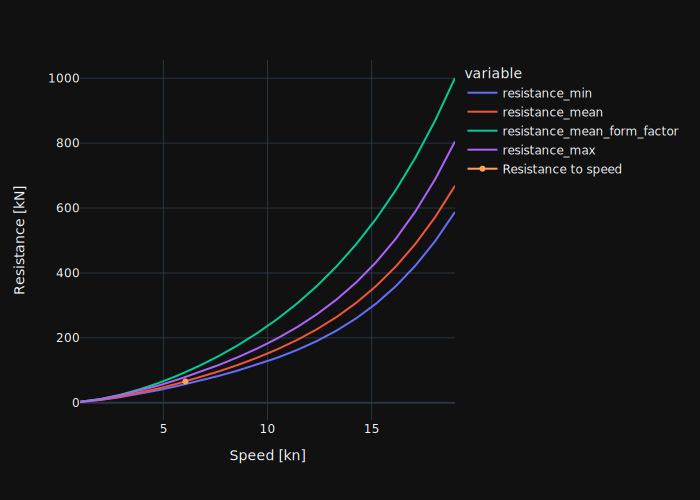

In [ ]:
import os
import random

import pandas as pd
from ship_model_lib.calm_water_resistance import (
    CalmWaterResistanceHollenbachSingleScrewDesignDraft,
    ResistanceLevel,
)
from plotly.graph_objs import Figure
import plotly.graph_objects as go

pd.options.plotting.backend = "plotly"

# Main dimensions
l_pp = 145
l_fore = 3.3
l_aft = 2.7
b_beam = 24
t_draft = 8.2
v_displacement = 18872.0
s_wetted_surface_area = 4400
a_bt = 14
s_app = 52
c_p = 0.6783
v_s = 17.5
dp = 4.9

l_wl = l_pp + l_aft
l_os = l_wl + l_fore
cb = v_displacement / (l_pp * b_beam * t_draft)

ship_dimensions_single_screw = ShipDimensionsHollenbachSingleScrew(
    b_beam_m=b_beam,
    lpp_length_between_perpendiculars_m=l_pp,
    lwl_length_water_line_m=l_wl,
    los_length_over_surface_m=l_os,
    cb_block_coefficient=cb,
    dp_diameter_propeller_m=dp,
    ta_draft_aft_m=t_draft,
    tf_draft_forward_m=t_draft,
    av_transverse_area_above_water_line_m2=383.76,
    area_bilge_keel_m2=52,
)

ship_model = CalmWaterResistanceHollenbachSingleScrewDesignDraft(
    ship_dimensions=ship_dimensions_single_screw
)

speed_kn = np.linspace(1, 19, 20)
resistance_force_k_n_minimum = ship_model.get_resistance_from_speed(
    speed_kn, resistance_level=ResistanceLevel.MINIMUM
)
resistance_force_k_n_mean = ship_model.get_resistance_from_speed(
    speed_kn, resistance_level=ResistanceLevel.MEAN
)
resistance_force_k_n_mean_with_form_factor = ship_model.get_resistance_from_speed(
    speed_kn, resistance_level=ResistanceLevel.MEAN, form_factor=0.6
)
resistance_force_k_n_maximum = ship_model.get_resistance_from_speed(
    speed_kn, resistance_level=ResistanceLevel.MAXIMUM
)
df_to_plot = pd.DataFrame(index=speed_kn)
df_to_plot["resistance_min"] = resistance_force_k_n_minimum
df_to_plot["resistance_mean"] = resistance_force_k_n_mean
df_to_plot["resistance_mean_form_factor"] = resistance_force_k_n_mean_with_form_factor
df_to_plot["resistance_max"] = resistance_force_k_n_maximum
fig: Figure = df_to_plot.plot()
fig.update_xaxes(title="Speed [kn]")
fig.update_yaxes(title="Resistance [kN]")

speed_kn_ref = random.random() * 19
resistance_k_n_ref = ship_model.get_resistance_from_speed(speed_kn_ref)
speed_kn_estimated = ship_model.get_speed_from_resistance(
    resistance_k_n=resistance_k_n_ref
)
fig.add_trace(
    go.Scatter(
        x=[speed_kn_estimated], y=[resistance_k_n_ref], name="Resistance to speed"
    )
)
fig.show(renderer="svg")

assert np.isclose(
    speed_kn_ref, speed_kn_estimated
), f"The estimated speed - {speed_kn_estimated} - is not equal to the answer - {speed_kn_ref}."

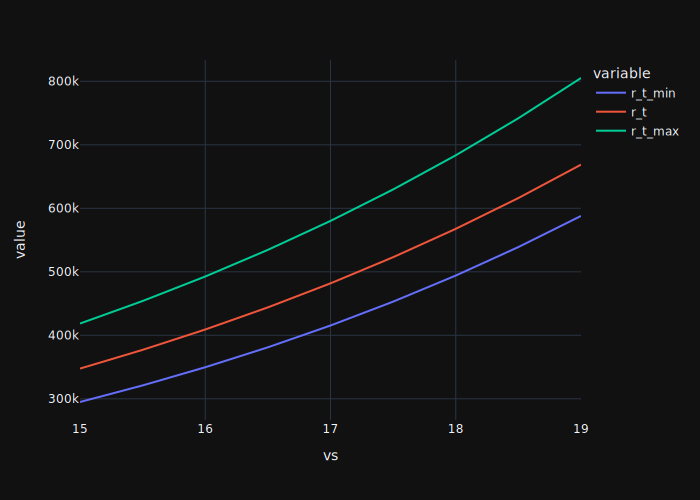

In [ ]:
# Testing the intermediate results

# Geometry factor
path_to_ref_data = os.path.join("test_data", "hollenbach_design_draft_coeff_ref.csv")
df_output_ref = pd.read_csv(path_to_ref_data)
assert np.isclose(ship_model._lfn_length_froude_number, 149.0)
assert np.isclose(ship_model._k_l, 0.9778, rtol=1e-4)
assert np.isclose(ship_model._k_bt, 1.4379, rtol=1e-4)
assert np.isclose(ship_model._k_lb, 0.2335, rtol=1e-3)
assert np.isclose(ship_model._k_ll, 0.8753, rtol=1e-4)
assert np.isclose(ship_model._k_ao, 0.9364, rtol=1e-4)
assert np.isclose(ship_model._k_pr, 0.9925, rtol=1e-4)
assert np.isclose(ship_model._k_tr, 1.0000, rtol=1e-4)
assert np.isclose(ship_model._k_shape_factor, 0.75938, rtol=1e-5)
assert np.isclose(ship_model.wetted_surface_area, 4448.453)

# Residual resistance coefficient estimation
df_output = pd.DataFrame()
df_output["vs"] = df_output_ref.vs.values
df_output["fn"] = ship_model._get_fn(kn_to_m_per_s(df_output_ref.vs.values))
fn_vec = df_output["fn"].values
df_output["c_r_min_std"] = ship_model._get_c_r_standard_min(fn_vec)
df_output["k_fr"] = ship_model._get_k_fr_high_froude_number_factor(fn_vec)
df_output["c_r_min_bt"] = ship_model._get_c_r_bt_min(fn_vec)
df_output["c_r_min"] = ship_model._get_c_r_min(fn_vec)
df_output["c_r_std"] = ship_model._get_c_r_standard(fn_vec)
df_output["c_r_bt"] = ship_model._get_c_r_bt(fn_vec)
df_output["c_r"] = ship_model._get_c_r(fn_vec)

overwrite_df_output = False
if overwrite_df_output:
    df_output.to_csv(path_to_ref_data)
for col_name in df_output:
    assert np.all(
        np.isclose(df_output_ref[col_name].values, df_output[col_name].values)
    )

# Resistance estimation
assert np.isclose(ship_model._c_a, 0.06e-3)
assert np.isclose(ship_model._c_aas, 0.08248e-3, rtol=1e-4)

path_to_ref_data = os.path.join("test_data", "hollenbach_design_draft_coeff_all.csv")
df_output_coeff_ref = pd.read_csv(path_to_ref_data)
df_output_coeff = pd.DataFrame()
df_output_coeff["vs"] = df_output_ref.vs.values
df_output_coeff["fn"] = fn_vec
df_output_coeff["re"] = ship_model.get_reynolds_number(
    kn_to_m_per_s(df_output.vs.values)
)
df_output_coeff["c_r_min"] = ship_model._get_c_r_min(fn_vec)
df_output_coeff["c_r"] = ship_model._get_c_r(fn_vec)
df_output_coeff["c_f"] = ship_model._get_c_f(kn_to_m_per_s(df_output.vs.values))
df_output_coeff["c_app"] = ship_model._get_c_app(kn_to_m_per_s(df_output.vs.values))
df_output_coeff["c_t_min"] = (
    df_output_coeff.c_r_min
    + df_output_coeff.c_f
    + df_output_coeff.c_app
    + ship_model._c_aas
    + ship_model._c_a
)
df_output_coeff["c_t"] = (
    df_output_coeff.c_r
    + df_output_coeff.c_f
    + df_output_coeff.c_app
    + ship_model._c_aas
    + ship_model._c_a
)
df_output_coeff["c_t_max"] = df_output_coeff.c_t * ship_model._factor_for_max_resistance
overwrite_df_output_coeff = False
if overwrite_df_output_coeff:
    df_output_coeff.to_csv(path_to_ref_data)
for col_name in df_output_coeff:
    assert np.all(
        np.isclose(
            df_output_coeff_ref[col_name].values, df_output_coeff[col_name].values
        )
    )

path_to_ref_data = os.path.join("test_data", "hollenbach_design_draft_resistance.csv")
df_output_resistance_ref = pd.read_csv(path_to_ref_data)
df_output_resistance = pd.DataFrame()
df_output_resistance["vs"] = df_output_ref.vs.values
df_output_resistance["fn"] = fn_vec
df_output_resistance["re"] = ship_model.get_reynolds_number(
    kn_to_m_per_s(df_output.vs.values)
)
df_output_resistance["r_t_min"] = ship_model._get_total_resistance_min(
    df_output.vs.values
)
df_output_resistance["r_t"] = ship_model._get_total_resistance_mean(df_output.vs.values)
df_output_resistance["r_t_max"] = ship_model._get_total_resistance_max(
    df_output.vs.values
)
overwrite_df_output_resistance = False
if overwrite_df_output_resistance:
    df_output_resistance.to_csv(path_to_ref_data)
for col_name in df_output_resistance:
    assert np.all(
        np.isclose(
            df_output_resistance_ref[col_name].values,
            df_output_resistance[col_name].values,
        )
    )
df_output_resistance.plot(x="vs", y=["r_t_min", "r_t", "r_t_max"]).show(renderer="svg")

4634.700963165507


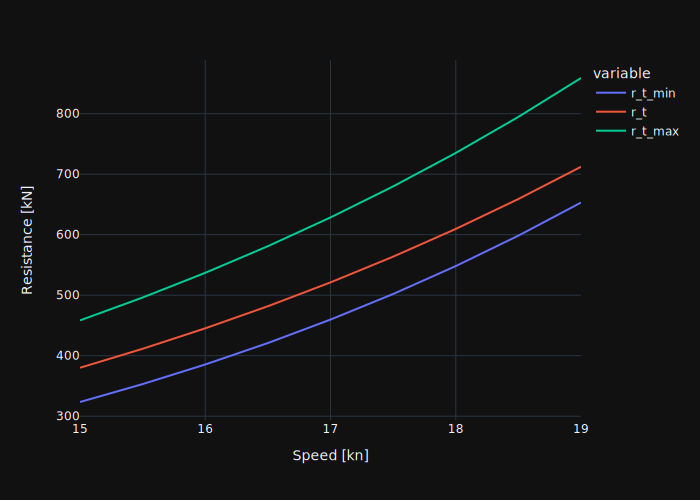

In [ ]:
from ship_model_lib.calm_water_resistance import (
    CalmWaterResistanceHollenbachTwinScrewDesignDraft,
)

ship_dimensions_twin_screw = ShipDimensionsHollenbachTwinScrew(
    b_beam_m=b_beam,
    lpp_length_between_perpendiculars_m=l_pp,
    lwl_length_water_line_m=l_wl,
    los_length_over_surface_m=l_os,
    cb_block_coefficient=cb,
    dp_diameter_propeller_m=dp,
    ta_draft_aft_m=t_draft,
    tf_draft_forward_m=t_draft,
    av_transverse_area_above_water_line_m2=383.76,
    area_bilge_keel_m2=52,
    number_rudders=2,
    number_shaft_bossings=2,
    number_shaft_brackets=2,
    number_thrusters=2,
)
ship_model = CalmWaterResistanceHollenbachTwinScrewDesignDraft(
    ship_dimensions=ship_dimensions_twin_screw
)

print(ship_model.wetted_surface_area)

df_output = pd.DataFrame()
df_output.index = df_output_ref.vs.values
df_output["r_t_min"] = ship_model.get_resistance_from_speed(
    df_output.index.values, resistance_level=ResistanceLevel.MINIMUM
)
df_output["r_t"] = ship_model.get_resistance_from_speed(df_output.index.values)
df_output["r_t_max"] = ship_model.get_resistance_from_speed(
    df_output.index.values, resistance_level=ResistanceLevel.MAXIMUM
)

fig = df_output.plot()
fig.update_xaxes(title="Speed [kn]")
fig.update_yaxes(title="Resistance [kN]")
fig.show(renderer="svg")